## Imports

In [1]:
import os
import shutil
import typing
import random

import tqdm
import torch
import numpy
import pandas
import torchvision
import matplotlib.pyplot as plt
import pytorch_metric_learning.utils
import pytorch_metric_learning.miners
import pytorch_metric_learning.losses
import pytorch_metric_learning.samplers
from torchvision.transforms import v2 as transforms

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
def fix_random():
    return set_random_seed(RANDOM_STATE)
fix_random()

cuda


## Load the small-faces dataset

In [2]:
! wget https://ml.gan4x4.ru/msu/dep-1.9/datasets/small_face_dataset.zip
! unzip small_face_dataset.zip -d dataset
! mv dataset/faces/* dataset/

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'mv' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
train_images = torchvision.datasets.ImageFolder("dataset/training")
test_images = torchvision.datasets.ImageFolder("dataset/testing")

If dataset in cell above too easy for, you can try http://vis-www.cs.umass.edu/lfw/lfw.tgz



## Create dataset & dataloader classes

### Dataset class

In [4]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            name: str,
            dataset: torchvision.datasets.ImageFolder,
            preload: bool = True,
            precalculate_transform: bool = True,
            transform: typing.Optional[transforms.Compose] = None
        ):
        self.name = name
        self.transform = None
        self.dataset = dataset
        self.classes = dataset.classes
        self.precalculated_transform = None

        # The dataset is not that big, so we might want to load it into RAM beforehand
        if preload or precalculate_transform:
            if precalculate_transform:
                # We might also want to precalculate the transform
                self.precalculated_transform = transform
                self.transform = transform
                transform = None
            # If precalculate_transform is True, self.transform is set, and __getitem__ will apply the transforms
            self.images, self.targets = self.load_all("Preload {}".format(self.name))
        # If precalculate_transform is True, this will be None
        self.transform = transform

    def load_all(self, progress_bar: bool = False):
        images = [ ]
        targets = [ ]
        for record in (tqdm.tqdm(self, desc = progress_bar.ljust(25)) if progress_bar else self):
            images.append(record[0])
            targets.append(record[1])
        # If no transforms are applied, torch.stack(images) will fail
        try: return torch.stack(images), targets
        except: return images, targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if hasattr(self, 'images') and hasattr(self, 'targets'):
            # If the data has been preloaded, use it
            image, target = self.images[idx], self.targets[idx]
        else:
            # Access the source
            image, target = self.dataset[idx]
        # Apply the transform if needed
        if self.transform is not None:
            image = self.transform(image)
        return image, target
    
    def channel_stats(self):
        images, _ = self.load_all() # Get the dataset as two tensors
        # Calculate the metrics
        mean = torch.mean(images, dim = [0, 2, 3])
        std = torch.std(images, dim = [0, 2, 3])
        return mean, std

### Calculate mean and std

In [5]:
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize((96, 96), antialias = True),
    torchvision.transforms.v2.Grayscale(),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True)
])

train_set = MyDataset("train", train_images, transform = transform, preload = True, precalculate_transform = True)
mean, std = train_set.channel_stats()
print(mean, std)
del train_set

Preload train            : 100%|██████████| 370/370 [00:00<00:00, 2618.26it/s]

tensor([0.4372]) tensor([0.1931])


### Create datasets

In [6]:
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize((96, 96), antialias = True),
    torchvision.transforms.v2.Grayscale(),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    torchvision.transforms.v2.Normalize(mean, std)
])

train_set = MyDataset("train", train_images, transform = transform, preload = True, precalculate_transform = True)
test_set = MyDataset("test", test_images, transform = transform, preload = True, precalculate_transform = True)

Preload test             : 100%|██████████| 30/30 [00:00<00:00, 2220.85it/s]


In [7]:
print("Train classes count", len(train_set.classes))
print("Test classes count", len(test_set.classes))
print("Images size", train_set[0][0].shape)
print("Train size", len(train_set))
print("Test size", len(test_set))

Train classes count 37
Test classes count 3
Images size torch.Size([1, 96, 96])
Train size 370
Test size 30


### Display examples

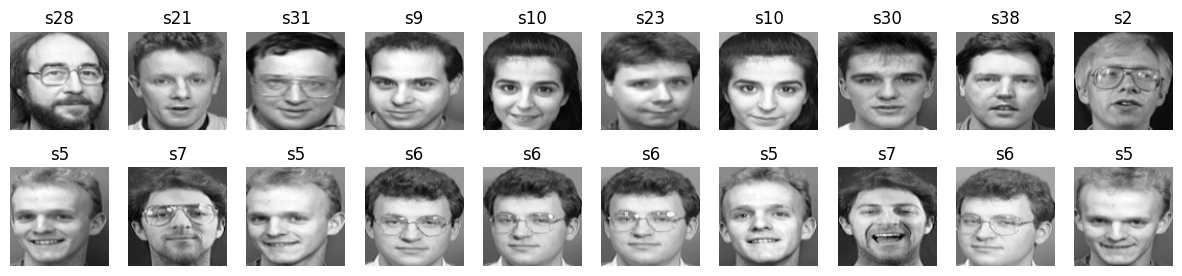

In [34]:
fix_random()

# Denormalization
denormalize = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Normalize(mean = torch.zeros_like(mean), std = 1 / std),
    torchvision.transforms.v2.Normalize(mean = -mean, std = torch.ones_like(std))
])

# Display some samples from each dataset
def display_examples(dataset: torch.utils.data.Dataset, row: int):
    train_loader = torch.utils.data.DataLoader(dataset, batch_size = 10, shuffle = True)
    for i, (image, label) in enumerate(zip(*next(iter(train_loader)))):
        plt.subplot(3, 10, i + 10 * (row - 1) + 1)
        plt.axis('off')
        plt.title('{}'.format(dataset.classes[label]))
        plt.imshow((denormalize(image).permute(1, 2, 0).numpy() * 255).astype(numpy.uint8), cmap = 'gray')

plt.rcParams["figure.figsize"] = (15, 5)
display_examples(train_set, 1)
display_examples(test_set, 2)

### Create balanced dataloaders

In [9]:
def show_class_distribtion(labels, classes):
    plt.figure(figsize = (10, 3))
    x, counts = labels.unique(return_counts = True)
    plt.bar(numpy.array(classes)[x], height = counts)

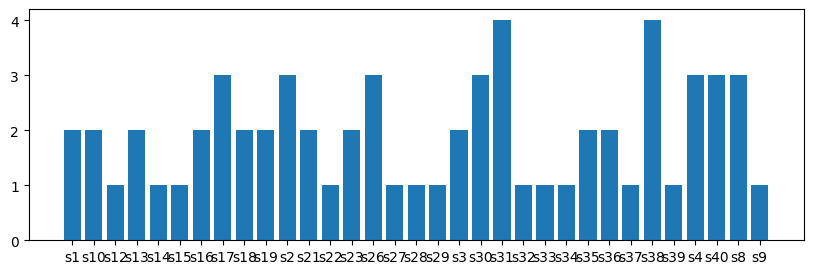

In [10]:
fix_random()
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True)
show_class_distribtion(next(iter(train_loader))[1], train_set.classes)

Случайная выборка очень несбалансирована. Это не подходит для обучения модели на триплетную функцию потерь. Воспользуемся семплером, чтобы в батчах получалось одинаковое количество объектов каждого класса

19

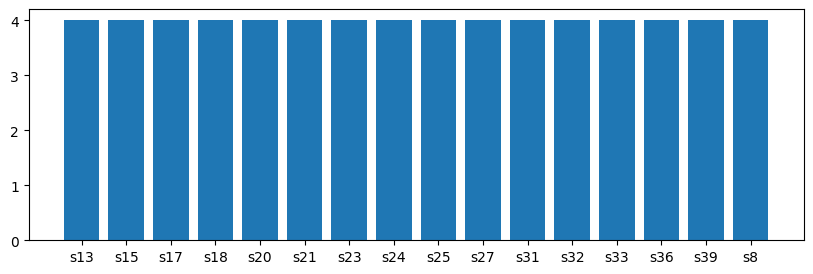

In [11]:
fix_random()
N_EPOCHS = 25
LENGTH_BEFORE_NEW_ITER = 1280
train_mpc_sampler = pytorch_metric_learning.samplers.MPerClassSampler(labels = train_set.targets, m = 4, length_before_new_iter = LENGTH_BEFORE_NEW_ITER)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, sampler = train_mpc_sampler)
show_class_distribtion(next(iter(train_loader))[1], train_set.classes)
len(train_loader)

Это гораздо лучше. \
\
Тестовая выборка достаточно маленькая, поэтому будем загружать её целиком в одном батче.

1

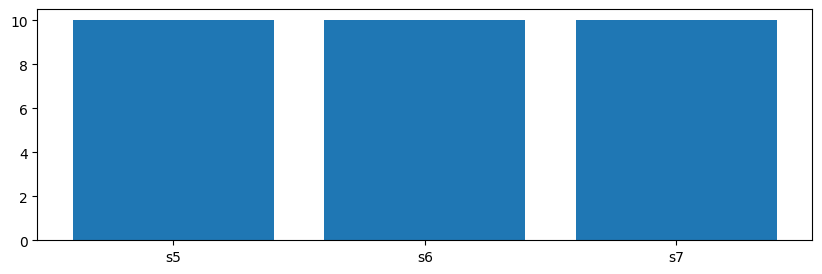

In [12]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size = len(test_set))
show_class_distribtion(next(iter(test_loader))[1], test_set.classes)
len(test_loader)

## Define the model for embedding extraction

In [13]:
EMBEDDING_SIZE = 256 # Embeddings of length 256 should be good enough

In [14]:
def MyModel():
    model = torchvision.models.resnet50(num_classes = EMBEDDING_SIZE)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size = (7, 7), padding = 3) # Change in_channels to 1, remove stride
    model.maxpool = torch.nn.MaxPool2d(2) # The images are already very small, 3x3 is too much
    return model

model = MyModel()
model(next(iter(test_loader))[0]).shape

torch.Size([30, 256])

## Train the model

In [15]:
MARGIN = 1 # Standard value in PyTorch TripletMarginLoss, should be good

Будем обучать модель на TripletMarginLoss библиотеки pytorch_metric_learning. Для этого необходимо разделять элементы батча на триплеты, для чего воспользуемся TripletMarginMiner.

In [16]:
fix_random()
train_miner = pytorch_metric_learning.miners.TripletMarginMiner(margin = MARGIN, type_of_triplets = "all")

images, labels = next(iter(train_loader))
embeddings = model(images)
print(embeddings.shape)

indices = train_miner(embeddings, labels)
print(len(indices), indices[0].shape, indices[1].shape, indices[2].shape)

torch.Size([64, 256])
3 torch.Size([11520]) torch.Size([11520]) torch.Size([11520])


In [17]:
criterion = pytorch_metric_learning.losses.TripletMarginLoss(margin = MARGIN)
loss = criterion(embeddings, labels, indices)
print(loss)

tensor(0.9675, grad_fn=<MeanBackward0>)


In [18]:
del images
del labels
del embeddings
del indices
del loss

Для валидации результата будем использовать метрики, вычисляемые AccuracyCalculator библиотеки pytorch_metric_learning. Посмотрим на значения метрик необученной модели.

In [19]:
metrics = pytorch_metric_learning.utils.accuracy_calculator.AccuracyCalculator()
def validate(model: torch.nn.Module, device: torch.device) -> dict:
    with torch.no_grad():
        images, targets = next(iter(test_loader))
        model = model.to(device)
        model.eval()
        embeddings = model(images.to(device))
        return metrics.get_accuracy(embeddings, targets.to(device))

validate(model, device)

d:\Programs\Programming\Python\lib\site-packages\faiss\contrib\torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


{'AMI': 0.4366953445130272,
 'NMI': 0.47645850313336935,
 'mean_average_precision': 0.7435159811201505,
 'mean_average_precision_at_r': 0.5792563198118753,
 'mean_reciprocal_rank': 0.9690476655960083,
 'precision_at_1': 0.9666666666666667,
 'r_precision': 0.5962962962962963}

In [20]:
def train(model: torch.nn.Module, n_epochs: int, device: torch.device) -> None:
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    for epoch in range(n_epochs):
        sum_loss = 0
        for (images, targets) in tqdm.tqdm(train_loader, desc = 'Epoch {}'.format(epoch + 1)):
            if len(targets) == 0:
                continue
            model.train() # Enter train mode
            optimizer.zero_grad() # Zero gradients
            embeddings = model(images.to(device))
            indices = train_miner(embeddings, targets)
            loss = criterion(embeddings, targets.to(device), indices)
            loss.backward() # Calculate gradients
            optimizer.step() # Update weights
            sum_loss += loss.item()
        train_loss = sum_loss / len(train_loader)
        metrics = validate(model, device)
        mean_avg_pr = metrics['mean_average_precision']
        AMI = metrics['AMI']
        NMI = metrics['NMI']
        print(f"Train loss: {train_loss:.5f}, Test MAP: {mean_avg_pr:.5f}, Test AMI: {AMI:.5f}, Test NMI: {NMI:.5f}")

fix_random()
train(model, N_EPOCHS, device)

Epoch 1: 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]


Train loss: 0.78778, Test MAP: 0.82974, Test AMI: 0.74683, Test NMI: 0.76497


Epoch 2: 100%|██████████| 19/19 [00:09<00:00,  1.97it/s]


Train loss: 0.72128, Test MAP: 0.98095, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 3: 100%|██████████| 19/19 [00:09<00:00,  1.99it/s]


Train loss: 0.59214, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 4: 100%|██████████| 19/19 [00:09<00:00,  1.95it/s]


Train loss: 0.56429, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 5: 100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


Train loss: 0.47182, Test MAP: 0.97998, Test AMI: 0.89237, Test NMI: 0.89969


Epoch 6: 100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


Train loss: 0.44133, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 7: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]


Train loss: 0.39722, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 8: 100%|██████████| 19/19 [00:10<00:00,  1.86it/s]


Train loss: 0.37305, Test MAP: 0.99181, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 9: 100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


Train loss: 0.37630, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 10: 100%|██████████| 19/19 [00:09<00:00,  1.98it/s]


Train loss: 0.34641, Test MAP: 0.99599, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 11: 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Train loss: 0.34553, Test MAP: 0.99812, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 12: 100%|██████████| 19/19 [00:09<00:00,  1.95it/s]


Train loss: 0.33570, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 13: 100%|██████████| 19/19 [00:09<00:00,  1.98it/s]


Train loss: 0.32125, Test MAP: 0.99620, Test AMI: 0.62463, Test NMI: 0.65662


Epoch 14: 100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Train loss: 0.30446, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 15: 100%|██████████| 19/19 [00:09<00:00,  1.97it/s]


Train loss: 0.29270, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 16: 100%|██████████| 19/19 [00:09<00:00,  2.00it/s]


Train loss: 0.28494, Test MAP: 1.00000, Test AMI: 0.62463, Test NMI: 0.65662


Epoch 17: 100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Train loss: 0.29271, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 18: 100%|██████████| 19/19 [00:09<00:00,  1.90it/s]


Train loss: 0.27874, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 19: 100%|██████████| 19/19 [00:10<00:00,  1.90it/s]


Train loss: 0.26838, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 20: 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Train loss: 0.25272, Test MAP: 0.99922, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 21: 100%|██████████| 19/19 [00:09<00:00,  1.90it/s]


Train loss: 0.24612, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 22: 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Train loss: 0.23643, Test MAP: 1.00000, Test AMI: 0.52931, Test NMI: 0.56837


Epoch 23: 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Train loss: 0.23003, Test MAP: 1.00000, Test AMI: 0.62463, Test NMI: 0.65662


Epoch 24: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]


Train loss: 0.21861, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 25: 100%|██████████| 19/19 [00:09<00:00,  1.90it/s]

Train loss: 0.20058, Test MAP: 1.00000, Test AMI: 1.00000, Test NMI: 1.00000


## Calculate metrics

In [21]:
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [22]:
validate(model, device)

{'AMI': 1.0,
 'NMI': 1.0,
 'mean_average_precision': 1.0,
 'mean_average_precision_at_r': 1.0,
 'mean_reciprocal_rank': 1.0,
 'precision_at_1': 1.0,
 'r_precision': 1.0}

Судя по значениям метрик, результат получился очень хороший

## Display the results

You can use faiss: https://github.com/facebookresearch/faiss

Посмотрим на реальные результаты. Вычислим эмбеддинги для тестовых данных.

In [23]:
images, labels = next(iter(test_loader))
labels = numpy.array(test_set.classes)[labels]
with torch.no_grad():
    embeddings = model(images.to(device))

Посмотрим на распределение Евклидовых расстояний между эмбеддингами.

In [24]:
matrix = [ [ "-1" ] * len(test_set) for i in range(len(test_set)) ]
for i, (emb1, label1) in enumerate(zip(embeddings, labels)):
    for j, (emb2, label2) in enumerate(zip(embeddings, labels)):
        euc_dist = torch.nn.functional.pairwise_distance(emb1, emb2).item()
        matrix[i][j] = "{0:.2f}".format(euc_dist)

pandas.options.display.max_columns = 30
df = pandas.DataFrame(matrix, columns = labels.tolist())
df.index = labels.tolist()
df

,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5,s6,s6,s6,s6,s6,s6,s6,s6,s6,s6,s7,s7,s7,s7,s7,s7,s7,s7,s7,s7
s5,0.00,46.37,5.51,20.70,3.78,15.74,13.57,8.27,35.03,27.75,185.89,214.29,192.02,184.10,213.38,223.68,218.22,223.43,202.44,227.93,323.22,313.48,283.25,337.52,281.10,327.06,327.49,330.29,335.30,341.07
s5,46.37,0.00,47.30,66.06,48.55,36.35,44.78,52.71,68.73,61.76,219.69,241.54,225.37,218.34,240.89,253.76,246.60,252.97,230.18,256.13,346.74,338.49,307.00,360.86,306.03,350.14,351.40,354.20,357.58,364.23
s5,5.51,47.30,0.00,19.94,6.15,18.51,16.75,11.78,36.58,29.18,186.24,215.69,192.60,184.39,214.89,224.70,219.36,224.49,203.82,229.24,324.63,314.31,284.96,338.83,282.09,328.26,328.77,331.71,336.71,342.58
s5,20.70,66.06,19.94,0.00,19.97,33.77,27.10,16.06,34.68,30.57,177.93,208.90,184.34,175.68,207.85,216.66,212.21,216.69,196.91,221.82,314.06,302.49,275.76,328.12,271.08,317.16,318.17,320.79,326.31,331.82
s5,3.78,48.55,6.15,19.97,0.00,17.47,15.00,9.08,33.34,25.89,182.42,211.36,188.60,180.66,210.50,220.60,215.18,220.38,199.52,224.99,322.39,313.01,281.84,336.74,280.36,326.70,326.54,329.53,334.67,340.41
s5,15.74,36.35,18.51,33.77,17.47,0.00,8.82,20.93,34.15,27.19,190.78,215.36,196.33,189.16,214.26,226.24,220.20,225.84,203.63,229.41,320.46,311.50,280.23,335.01,278.66,324.06,325.13,327.58,332.17,338.06
s5,13.57,44.78,16.75,27.10,15.00,8.82,0.00,15.91,28.05,21.77,186.45,211.62,191.94,184.71,210.35,222.09,216.42,221.80,199.80,225.45,314.62,305.03,274.89,329.21,272.39,317.81,319.38,321.56,326.39,332.10
s5,8.27,52.71,11.78,16.06,9.08,20.93,15.91,0.00,34.16,28.13,184.12,212.75,190.10,182.28,211.65,221.90,216.72,221.75,200.88,226.23,320.10,310.04,280.55,334.46,277.91,323.57,324.56,326.96,332.19,337.73
s5,35.03,68.73,36.58,34.68,33.34,34.15,28.05,34.16,0.00,8.42,162.26,186.92,167.23,160.47,185.35,197.19,191.97,197.08,175.02,200.52,292.76,284.81,250.54,307.91,250.67,297.84,297.24,299.84,305.51,310.73
s5,27.75,61.76,29.18,30.57,25.89,27.19,21.77,28.13,8.42,0.00,166.18,191.75,171.51,164.43,190.45,201.91,196.49,201.72,179.87,205.45,300.40,292.46,258.16,315.35,258.51,305.65,304.69,307.60,313.09,318.50


![Alternative Text][1702123239021]

[1702123239021]: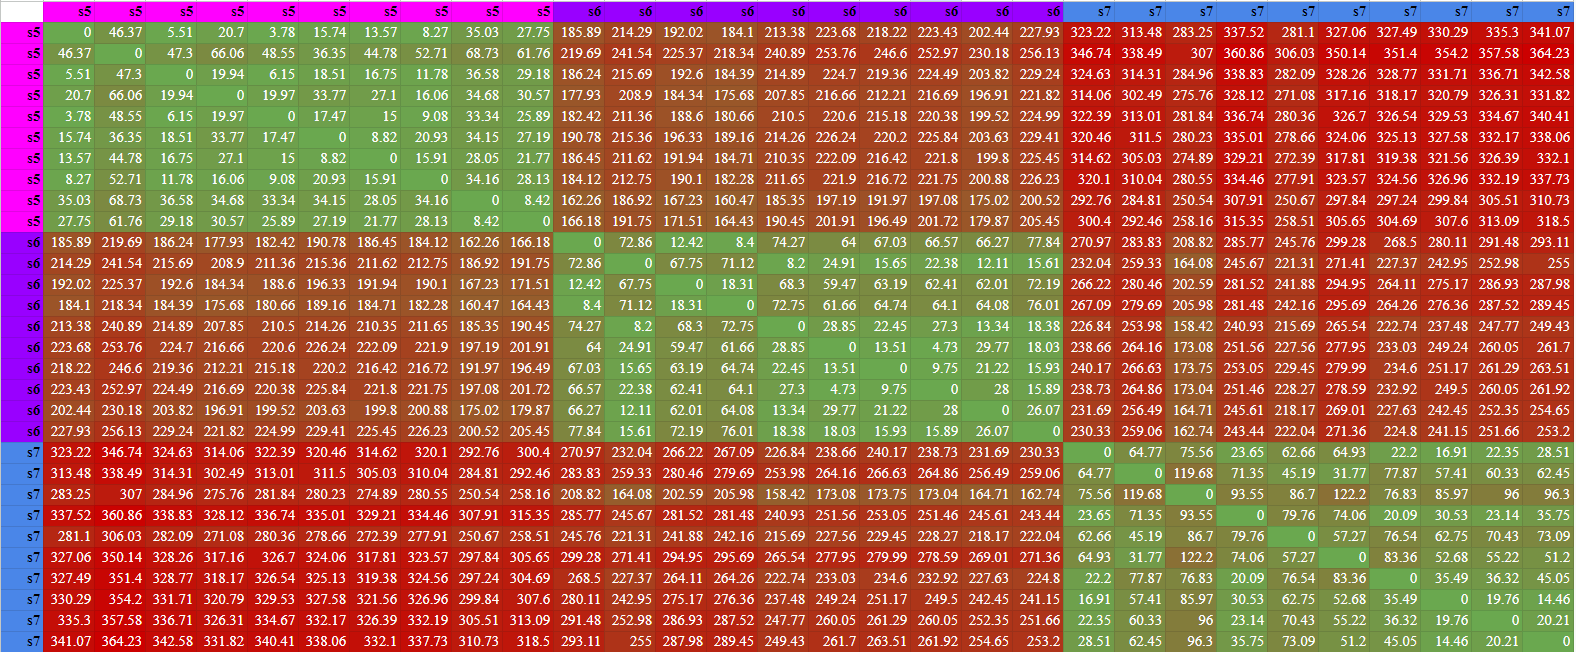

Результат выглядит достаточно хорошо: расстояния между эмбеддингами картинок одного человека заметно меньше расстояний между эмбеддингами разных людей.

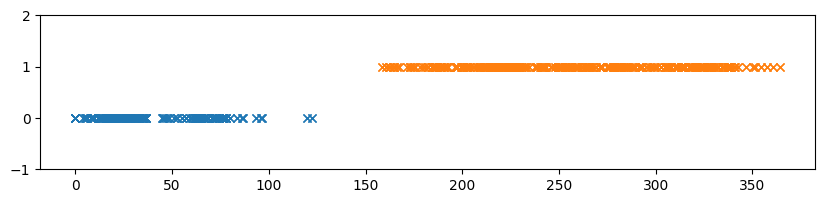

In [25]:
correct_dists = [ ]
incorrect_dists = [ ]
for i, (emb1, label1) in enumerate(zip(embeddings, labels)):
    for j, (emb2, label2) in enumerate(zip(embeddings, labels)):
        euc_dist = torch.nn.functional.pairwise_distance(emb1, emb2).item()
        if label1 == label2: correct_dists.append(euc_dist)
        else: incorrect_dists.append(euc_dist)

plt.figure(figsize = (10, 2))
plt.ylim(-1, 2)
plt.plot(correct_dists, numpy.zeros_like(correct_dists), 'x')
plt.plot(incorrect_dists, numpy.ones_like(incorrect_dists), 'x')

Явно видно, что расстояния между объектами одного класса и объектами разных классов хорошо разделимы. Все "хорошие" расстояния меньше 150, а "плохие" - больше 150. Таким образом, на тестовой выборке модель работает идеально. \
 \
Для интереса проведем аналогичный анализ для косинусного расстояния.

In [26]:
matrix = [ [ "-1" ] * len(test_set) for i in range(len(test_set)) ]
for i, (emb1, label1) in enumerate(zip(embeddings, labels)):
    for j, (emb2, label2) in enumerate(zip(embeddings, labels)):
        cos_dist = torch.nn.functional.cosine_similarity(emb1, emb2, dim = 0).item()
        matrix[i][j] = "{0:.2f}".format(cos_dist)

pandas.options.display.max_columns = 30
df = pandas.DataFrame(matrix, columns = labels.tolist())
df.index = labels.tolist()
df

,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5,s6,s6,s6,s6,s6,s6,s6,s6,s6,s6,s7,s7,s7,s7,s7,s7,s7,s7,s7,s7
s5,1.00,0.97,1.00,0.99,1.00,0.99,1.00,1.00,1.00,1.00,0.16,-0.11,0.08,0.17,-0.14,-0.09,-0.06,-0.09,-0.05,-0.16,-0.60,-0.49,-0.69,-0.56,-0.55,-0.57,-0.57,-0.62,-0.58,-0.63
s5,0.97,1.00,0.96,0.92,0.96,0.99,0.98,0.95,0.96,0.96,-0.00,-0.20,-0.08,0.01,-0.24,-0.22,-0.17,-0.21,-0.15,-0.26,-0.64,-0.55,-0.72,-0.60,-0.60,-0.61,-0.61,-0.66,-0.61,-0.66
s5,1.00,0.96,1.00,0.99,1.00,0.99,1.00,1.00,1.00,1.00,0.17,-0.10,0.09,0.18,-0.14,-0.09,-0.06,-0.08,-0.05,-0.16,-0.59,-0.49,-0.68,-0.55,-0.54,-0.56,-0.56,-0.61,-0.58,-0.63
s5,0.99,0.92,0.99,1.00,0.99,0.97,0.98,0.99,0.99,0.99,0.21,-0.08,0.13,0.23,-0.11,-0.05,-0.03,-0.04,-0.02,-0.12,-0.53,-0.41,-0.63,-0.49,-0.47,-0.50,-0.50,-0.55,-0.52,-0.56
s5,1.00,0.96,1.00,0.99,1.00,0.99,1.00,1.00,1.00,1.00,0.18,-0.09,0.10,0.20,-0.12,-0.07,-0.04,-0.07,-0.03,-0.14,-0.60,-0.50,-0.69,-0.56,-0.55,-0.58,-0.57,-0.62,-0.59,-0.64
s5,0.99,0.99,0.99,0.97,0.99,1.00,1.00,0.99,0.99,0.99,0.08,-0.15,0.01,0.10,-0.19,-0.15,-0.12,-0.14,-0.10,-0.21,-0.61,-0.51,-0.70,-0.57,-0.56,-0.58,-0.58,-0.63,-0.59,-0.64
s5,1.00,0.98,1.00,0.98,1.00,1.00,1.00,0.99,0.99,0.99,0.09,-0.15,0.02,0.11,-0.18,-0.14,-0.11,-0.14,-0.10,-0.20,-0.59,-0.48,-0.69,-0.55,-0.54,-0.55,-0.56,-0.61,-0.57,-0.62
s5,1.00,0.95,1.00,0.99,1.00,0.99,0.99,1.00,0.99,0.99,0.16,-0.11,0.08,0.18,-0.14,-0.09,-0.07,-0.09,-0.05,-0.16,-0.59,-0.48,-0.68,-0.54,-0.53,-0.55,-0.56,-0.60,-0.57,-0.61
s5,1.00,0.96,1.00,0.99,1.00,0.99,0.99,0.99,1.00,1.00,0.19,-0.06,0.12,0.21,-0.10,-0.05,-0.02,-0.04,-0.01,-0.11,-0.57,-0.46,-0.65,-0.52,-0.52,-0.55,-0.53,-0.59,-0.55,-0.60
s5,1.00,0.96,1.00,0.99,1.00,0.99,0.99,0.99,1.00,1.00,0.20,-0.06,0.12,0.21,-0.09,-0.05,-0.02,-0.04,-0.00,-0.11,-0.58,-0.49,-0.66,-0.54,-0.54,-0.57,-0.55,-0.60,-0.57,-0.62


![Alternative Text][1702124140656]

[1702124140656]: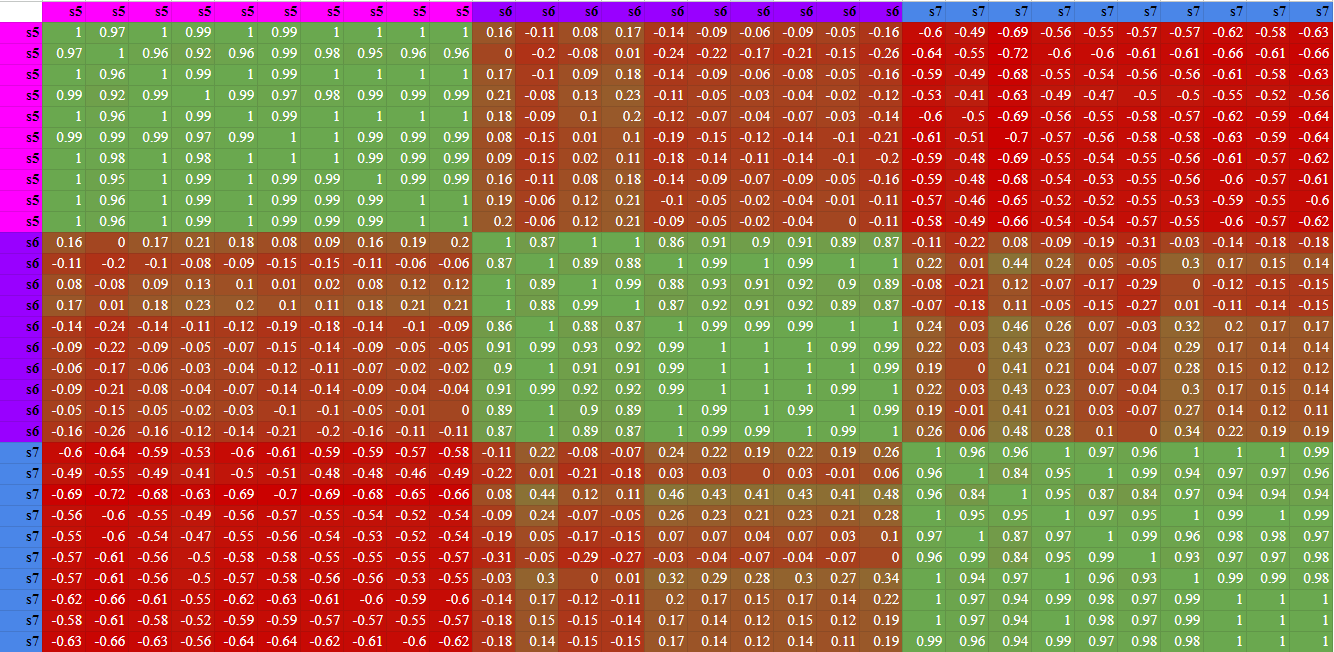

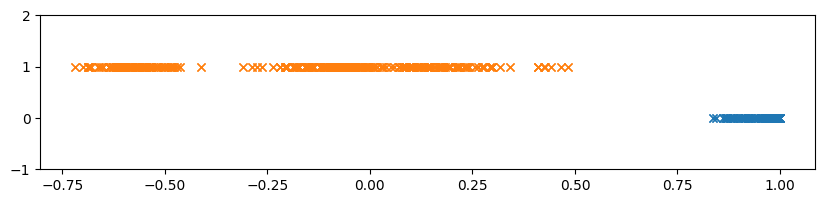

In [27]:
correct_dists = [ ]
incorrect_dists = [ ]
for i, (emb1, label1) in enumerate(zip(embeddings, labels)):
    for j, (emb2, label2) in enumerate(zip(embeddings, labels)):
        cos_dist = torch.nn.functional.cosine_similarity(emb1, emb2, dim = 0).item()
        if label1 == label2: correct_dists.append(cos_dist)
        else: incorrect_dists.append(cos_dist)

plt.figure(figsize = (10, 2))
plt.ylim(-1, 2)
plt.plot(correct_dists, numpy.zeros_like(correct_dists), 'x')
plt.plot(incorrect_dists, numpy.ones_like(incorrect_dists), 'x')

Результат аналогичен: на тестовой выборке модель работает идеально. \
 \
Выберем несколько объектов, чтобы посмотреть на сами картинки. Возьмем картинки под номерами 0 и 4 как "простые" примеры для первого объекта, картинку 1 как "сложный" пример первого объекта (расстояния до остальных картинок первого объекта достаточно велики), а также по одному примеру других объектов - картинки 15 и 25

In [28]:
embeddings = [ embeddings[0], embeddings[4], embeddings[1], embeddings[15], embeddings[25] ]
images = [ images[0], images[4], images[1], images[15], images[25] ]
labels = [ labels[0], labels[4], labels[1], labels[15], labels[25] ]

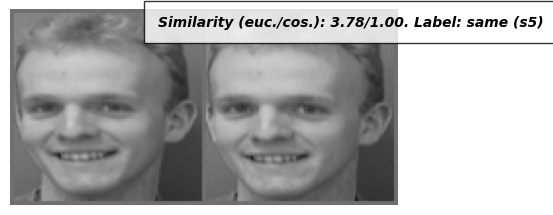

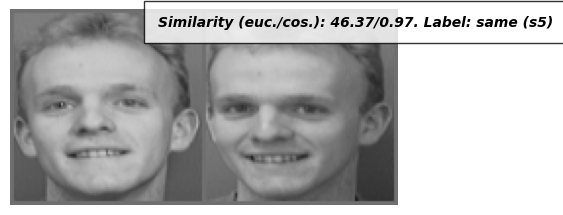

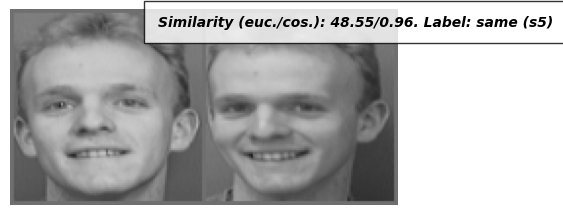

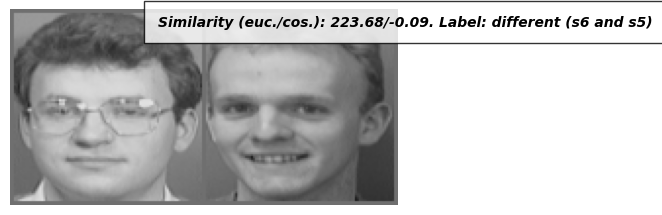

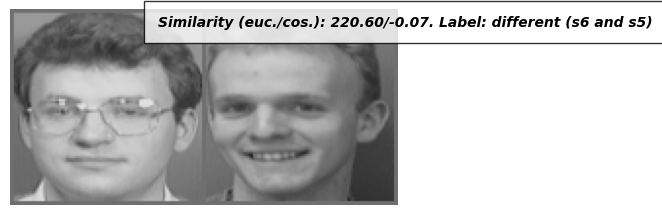

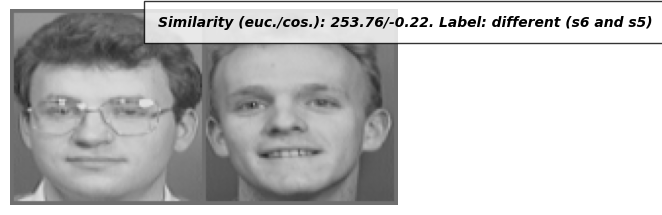

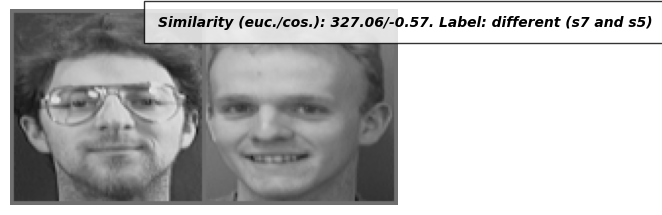

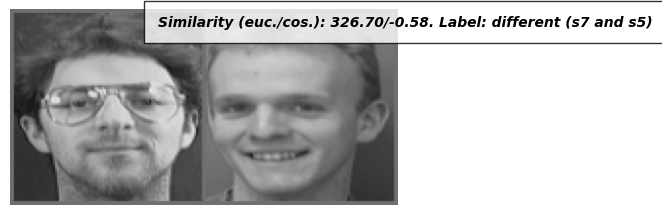

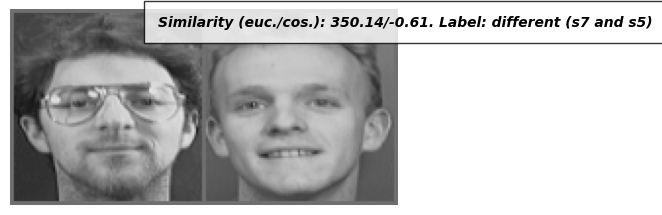

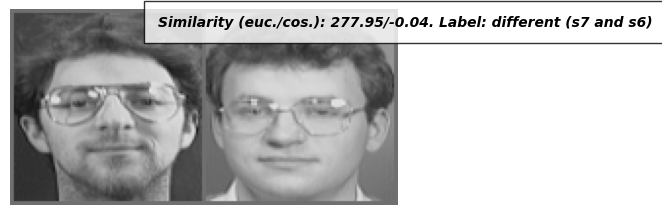

In [32]:
def imshow(img, text):
    plt.axis("off")
    plt.rcParams["figure.figsize"] = (5, 5)
    plt.imshow((denormalize(img).permute(1, 2, 0).numpy() * 255).astype(numpy.uint8), cmap = 'gray')
    plt.text(75, 8, text, style = 'italic', fontweight = 'bold', bbox = {'facecolor': 'white', 'alpha': 0.8, 'pad': 10 })
    plt.show()

for i, (emb1, img1, label1) in enumerate(zip(embeddings, images, labels)):
    for j, (emb2, img2, label2) in enumerate(zip(embeddings, images, labels)):
        if i <= j:
            continue
        euc_dist = torch.nn.functional.pairwise_distance(emb1, emb2).item()
        cos_dist = torch.nn.functional.cosine_similarity(emb1, emb2, dim = 0).item()
        
        concatenated = torch.stack((img1, img2))
        label = "same ({})".format(label1) if label1 == label2 else "different ({} and {})".format(label1, label2)
        imshow(torchvision.utils.make_grid(concatenated), 'Similarity (euc./cos.): {:.2f}/{:.2f}. Label: {}'.format(euc_dist, cos_dist, label))

## Place for conclusion

Таким образом, данный датасет очень простой. Достаточно маленькая модель (ResNet-50) после обучения на триплетную функцию потерь извлекает эмбеддинги, позволяющие идеально определять, являются ли две картинки фотографиями одного человека. И анализ результатов это подтверждает: Евклидово расстояние между эмбедингами фотографий одного человека всегда меньше 150, а разных людей - больше 150; косинусное расстояние между эмбеддингами фотографий одного человека больше 0.75, а разных людей - меньше. Все вычисленные метрики, соответственно, равны единице - наилучшее возможное значение.